In [11]:
import matplotlib.pyplot as plt


def roc_plot(y_test, y_pred):
    from sklearn.metrics import roc_curve, auc
    from itertools import cycle
    
    rice = {
        0: 'Cammeo',
        1: 'Osmanscik',
    }

    plt.figure(figsize=(10, 5))

    colors = cycle(['red', 'blue'])

    for i, class_name in rice.items():
        y_test = [1 if label == i else 0 for label in y_test]
        y_pred = [pred[i] for pred in y_pred]

        fpr, tpr, _ = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        
        color = next(colors)

        plt.subplot(1, len(rice), i + 1)
        plt.plot(fpr, tpr, color=color, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2)
        plt.xlim([-.05, 1.05])
        plt.ylim([.05, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {class_name}')
        plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()


In [12]:
import numpy as np
import pandas as pd
import seaborn as sns

cols = ['Area', 'Perimeter', 'Major_Axis_Length', 'Minor_Axis_Length',
        'Eccentricity', 'Convex_Area', 'Extent', 'Class']

data = pd.read_csv('./data/Rice_Cammeo_Osmancik.arff', names=cols)
data['Class'] = (data['Class'] == 'Osmancik').astype(int)

In [13]:
from sklearn.preprocessing import StandardScaler

x = data.iloc[:, 0:7].values
y = data.iloc[:,-1]

scaler = StandardScaler()
x = scaler.fit_transform(x)

In [14]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=.3)
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=.15)

cat_model = CatBoostClassifier(learning_rate=0.05, task_type='GPU', verbose=200)

cat_model.fit(x_train, y_train, eval_set=(x_val, y_val))

print(cat_model.get_feature_importance())

y_pred = cat_model.predict(x_test)
y_prob = cat_model.predict_proba(x_test)

0:	learn: 0.6211249	test: 0.6235322	best: 0.6235322 (0)	total: 29.3ms	remaining: 29.2s
200:	learn: 0.1348469	test: 0.2015387	best: 0.1984460 (116)	total: 5.7s	remaining: 22.7s
400:	learn: 0.1178694	test: 0.2088406	best: 0.1984460 (116)	total: 10.9s	remaining: 16.3s
600:	learn: 0.1064950	test: 0.2157907	best: 0.1984460 (116)	total: 16.5s	remaining: 10.9s
800:	learn: 0.0922188	test: 0.2218814	best: 0.1984460 (116)	total: 21.7s	remaining: 5.39s
999:	learn: 0.0824350	test: 0.2227857	best: 0.1984460 (116)	total: 27.3s	remaining: 0us
bestTest = 0.1984459932
bestIteration = 116
Shrink model to first 117 iterations.
[10.09936418 19.59876477 32.37110237 11.42525553 14.47387935  8.90356186
  3.12807194]


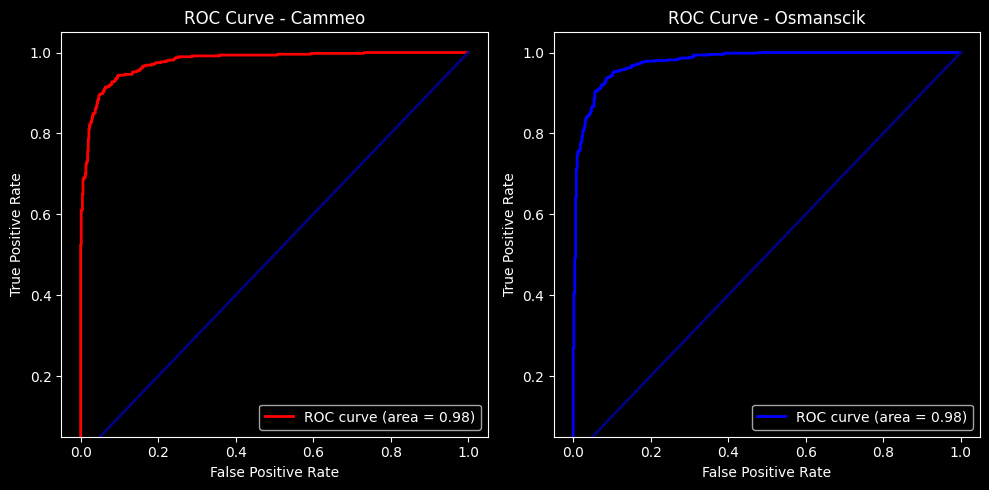

              precision    recall  f1-score   support

           0       0.90      0.91      0.91       482
           1       0.94      0.93      0.93       661

    accuracy                           0.92      1143
   macro avg       0.92      0.92      0.92      1143
weighted avg       0.92      0.92      0.92      1143

[[441  41]
 [ 48 613]]


In [15]:
from sklearn.metrics import classification_report, confusion_matrix

roc_plot(y_test, y_prob)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))